In [1]:
# Mounting files from gdrive
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'termios'

In [2]:
# Installing fscparser to parse fcs files

!pip install fcsparser

In [3]:
!unzip FCM\ Data\ for\ Kartik.zip

unzip:  cannot find or open FCM Data for Kartik.zip, FCM Data for Kartik.zip.zip or FCM Data for Kartik.zip.ZIP.


In [4]:
cd gdrive/MyDrive/FCM\ Data\ for\ Kartik

/content/gdrive/MyDrive/FCM Data for Kartik


## **Abbreviations for components of FCS filenames:**



> 




*   C: Combination of Spectinomycin and Tetracycline antibiotics
*   S: Spectinomycin
*   T: Tetracycline
*   H: High Concentration
*   M: Medium Concentration
*   L: Low Concentration
*   NC: Negative control
*   PC: Positive Control
*   IND0: Inoculum on Day 0
*   D1, D2, D3, D4, D5: Days 1 to 5
*   1, 2, 3: Triplicates of each sample













In [32]:
#Importing Libraries

import argparse
import keras
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from sys import argv
from collections import defaultdict
import fcsparser as fcsp
import re
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid, train_test_split, RepeatedStratifiedKFold, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.gaussian_process.kernels import RBF

import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [33]:
# Importing data

def load_data(dir):
    print('---- loading data ---->')
    data = {}
    for dirname, _, filename in os.walk(dir):
        for file in filename:
            path = os.path.join(dirname, file)
            # Slicing in order to remove .fcs from filename
            f_name = ''.join(list(file)[:-4])
            data[f_name] = pd.DataFrame(fcsp.parse(path, meta_data_only=False, reformat_meta=True)[1])
    print('---- Data Loaded ----')
    return data, fcsp.parse(path, meta_data_only=False, reformat_meta=True)[0]['_channels_']
 

'''
for dirname, _, filename in os.walk(HERE):
    for file in filename:
      path = os.path.join()
        meta = fcsparser.parse(, meta_data_only=True, reformat_meta=True)
'''

def prepData(x,scaler=None):
        """
        Normalize data
        """
        if not scaler:
                scaler = StandardScaler().fit(x)
        x_transformed= np.nan_to_num(np.array(scaler.transform(x)))
        return normalize(x_transformed),scaler

# Loading fcs file data into a dictionary
global path

dir = os.path.abspath(os.path.dirname('./CHD1_1.fcs'))
dir = os.path.join(dir, 'FCM Data for Kartik')
data, channels = load_data(dir)

# Function to return list of different taken samples
def sample_list(det = data):
    return set([sample[0:3] for sample in det.keys()])


# Function to check the dimensions of our fcs files
def checkDimensions(data, dimensions):
    for sample in data:
        if data[sample].shape != dimensions: print(sample, data[sample].shape)
    return 

#Function to OneHotEncode column vector dataframe to return an OnehotEncoded/LabelEncoded
def transform_y(y,dencoder = 'labelencoder'):
    if dencoder == "labelencoder":
        le = LabelEncoder().fit(y)
        y_ = pd.DataFrame(le.transform(y))
        labels = le.classes_
        return y_, labels
    
    else:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder_df = pd.DataFrame(encoder.fit(y))
        y_enc = encoder_df.transform(y).toarray()
        return y_enc, encoder_df.categories_



---- loading data ---->
---- Data Loaded ----


In [34]:
# Filtering FCS files with improper dimensions

checkDimensions(data, data[random.choice(list(data.keys()))].shape)

CMD4_1 (99906, 12)
SHD1_2 (100021, 12)
SHD2_3 (99670, 12)
TMD4_2 (100094, 12)


In [35]:
# Checking correlation between features

corr_df = pd.DataFrame(data['CHD1_1'])
print(type(corr_df))#New dataframe to calculate correlation between features
cor= corr_df.corr(method='pearson')
print(cor)

<class 'pandas.core.frame.DataFrame'>
                   FSC-A     FSC-H     SSC-A    FITC-A      PE-A  PE-Cy5-A  \
FSC-A           1.000000  0.958090  0.748268  0.631438  0.336811  0.240610   
FSC-H           0.958090  1.000000  0.736352  0.633651  0.336818  0.244204   
SSC-A           0.748268  0.736352  1.000000  0.678663  0.362447  0.190859   
FITC-A          0.631438  0.633651  0.678663  1.000000  0.365784  0.275923   
PE-A            0.336811  0.336818  0.362447  0.365784  1.000000  0.116409   
PE-Cy5-A        0.240610  0.244204  0.190859  0.275923  0.116409  1.000000   
PE-Cy7-A        0.231699  0.237122  0.184006  0.255722  0.110588  0.925354   
APC-A           0.337875  0.336994  0.356644  0.361102  0.191048  0.618316   
APC-Cy7-A       0.145428  0.148702  0.109799  0.174096  0.068986  0.679119   
Pacific Blue-A  0.341462  0.323263  0.468027  0.318007  0.173482  0.061353   
AmCyan-A        0.497797  0.489128  0.604574  0.504620  0.269689  0.109624   
Time            0.006220  

# Exploratory Data Analysis:


In [36]:
print('First five rows of sample fcs file -->')
random_sample = random.choice(list(data.keys()))
random_fcs_sample = data[random_sample]
random_fcs_sample.head()


First five rows of sample fcs file -->


,FSC-A,FSC-H,SSC-A,FITC-A,PE-A,PE-Cy5-A,PE-Cy7-A,APC-A,APC-Cy7-A,Pacific Blue-A,AmCyan-A,Time
0,1666.400024,2372.0,3028.409912,71.279999,403.920013,3.960000,-12.870000,-184.800003,165.600006,792.430054,1146.680054,55.599998
1,76.800003,1183.0,5878.620117,719.729980,772.200012,284.130005,0.000000,958.400024,-7.200000,3565.390137,3648.230225,55.599998
2,170.400009,650.0,1243.440063,-61.380001,-345.510010,45.540001,378.179993,171.199997,12.000000,-148.240005,27.250000,55.700001
3,171.199997,719.0,1094.940063,-54.450001,-294.029999,93.059998,94.050003,120.000000,-104.000000,431.640015,55.590000,55.700001
4,151.199997,755.0,438.570007,-104.940002,-19.799999,35.639999,2.970000,-156.000000,-74.400002,225.630005,236.530014,55.700001


In [37]:
# Printing Channels present in each fcs file
channels

,$PnN,$PnR,$PnB,$PnE,$PnV,$PnG
Channel Number,,,,,,
1,FSC-A,262144,32,"[0, 0]",478,1.0
2,FSC-H,262144,32,"[0, 0]",478,1.0
3,SSC-A,262144,32,"[0, 0]",324,1.0
4,FITC-A,262144,32,"[0, 0]",610,1.0
5,PE-A,262144,32,"[0, 0]",637,1.0
6,PE-Cy5-A,262144,32,"[0, 0]",606,1.0
7,PE-Cy7-A,262144,32,"[0, 0]",775,1.0
8,APC-A,262144,32,"[0, 0]",833,1.0
9,APC-Cy7-A,262144,32,"[0, 0]",715,1.0


In [38]:
# Checking for NaN values in each of the fcs files
sum([(sum(data[key].isnull().sum(),)) for key in data.keys()])

0

In [39]:
data.keys()

dict_keys(['CHD1_1', 'CHD1_2', 'CHD1_3', 'CHD2_1', 'CHD2_2', 'CHD2_3', 'CHD3_1', 'CHD3_2', 'CHD3_3', 'CHD4_1', 'CHD4_2', 'CHD4_3', 'CHD5_1', 'CHD5_2', 'CHD5_3', 'CLD1_1', 'CLD1_2', 'CLD1_3', 'CLD2_1', 'CLD2_2', 'CLD2_3', 'CLD3_1', 'CLD3_2', 'CLD3_3', 'CLD4_1', 'CLD4_2', 'CLD4_3', 'CLD5_1', 'CLD5_2', 'CLD5_3', 'CMD1_1', 'CMD1_2', 'CMD1_3', 'CMD2_1', 'CMD2_2', 'CMD2_3', 'CMD3_1', 'CMD3_2', 'CMD3_3', 'CMD4_1', 'CMD4_2', 'CMD4_3', 'CMD5_1', 'CMD5_2', 'CMD5_3', 'IND0_1', 'IND0_2', 'IND0_3', 'NCD1_1', 'NCD1_2', 'NCD1_3', 'NCD2_1', 'NCD2_2', 'NCD2_3', 'NCD3_1', 'NCD3_2', 'NCD3_3', 'NCD4_1', 'NCD4_2', 'NCD4_3', 'NCD5_1', 'NCD5_2', 'NCD5_3', 'PCD1_1', 'PCD1_2', 'PCD1_3', 'PCD2_1', 'PCD2_2', 'PCD2_3', 'PCD3_1', 'PCD3_2', 'PCD3_3', 'PCD4_1', 'PCD4_2', 'PCD4_3', 'PCD5_1', 'PCD5_2', 'PCD5_3', 'SHD1_1', 'SHD1_2', 'SHD1_3', 'SHD2_1', 'SHD2_2', 'SHD2_3', 'SHD3_1', 'SHD3_2', 'SHD3_3', 'SHD4_1', 'SHD4_2', 'SHD4_3', 'SHD5_1', 'SHD5_2', 'SHD5_3', 'SLD1_1', 'SLD1_2', 'SLD1_3', 'SLD2_1', 'SLD2_2', 'SLD2_3',

In [40]:
# Printing available features in each of the fcs file -->

features = random_fcs_sample.columns
print('Features in each fcs file : {}'.format(', '.join(features)))

Features in each fcs file : FSC-A, FSC-H, SSC-A, FITC-A, PE-A, PE-Cy5-A, PE-Cy7-A, APC-A, APC-Cy7-A, Pacific Blue-A, AmCyan-A, Time


<AxesSubplot:title={'center':'Features Standard Deviation for SMD3_3'}>

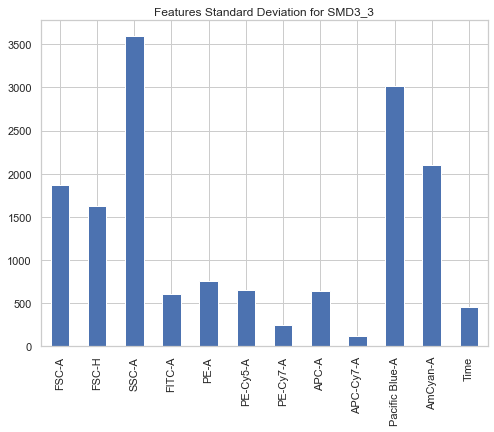

In [41]:
# Plotting and comparing the standard deviation of each of the input features:

random_fcs_sample[features].std().plot(kind='bar', figsize=(8,6), title=f"Features Standard Deviation for {random_sample}")

<AxesSubplot:>

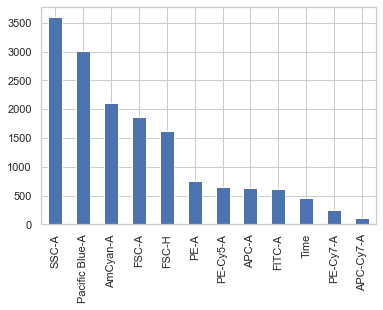

In [42]:
# Plotting the hist data in non-increasing order 

features_highest_variance = random_fcs_sample[features].std().sort_values(ascending=False)
features_highest_variance.plot(kind = 'bar')

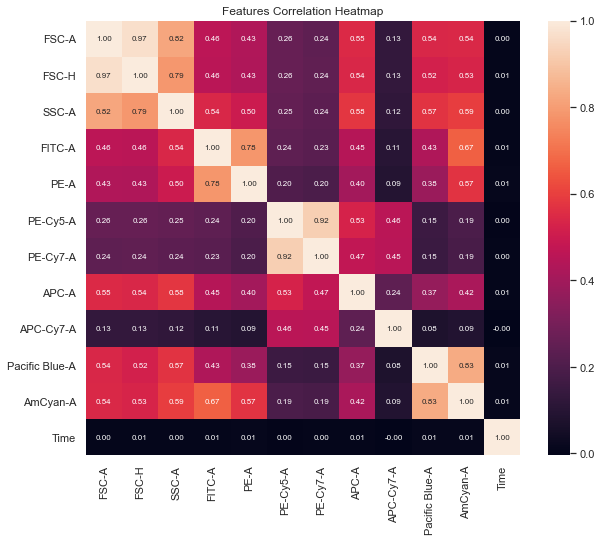

In [43]:
#Checking data colinearity via heatmap

cm = np.corrcoef(random_fcs_sample[features].values.T)
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=features, xticklabels=features)
plt.title('Features Correlation Heatmap')
plt.show()

There is a very high correlation (> 0.6) between some features which could hurt the performance of some ML algorithms.

So, some of the above features will be target for removal in feature selection

Usually, we take only three features, which are FSC-A,  SSC-A and AmCyan-A

In [13]:
data

{'CHD1_1':              FSC-A   FSC-H        SSC-A     FITC-A        PE-A   PE-Cy5-A  \
 0        96.800003   995.0  1552.320068   2.970000   63.360001  70.290001   
 1       252.800003   707.0  1641.420044  87.120003   38.610001  59.400002   
 2       248.000000   791.0  1152.359985 -89.099998 -523.710022   1.980000   
 3       229.600006   827.0   708.840027  58.410000    1.980000  39.599998   
 4       289.600006   800.0  1036.530029  26.730000 -621.720032  53.459999   
 ...            ...     ...          ...        ...         ...        ...   
 99995  1481.599976  1046.0   420.750000 -14.850000  319.769989  35.639999   
 99996   860.000000   891.0   544.500000 -46.529999 -237.600006 -22.770000   
 99997  2175.199951  1157.0  1025.640015 -58.410000  303.929993  14.850000   
 99998  1770.400024  1002.0   590.039978 -52.470001  258.390015  16.830000   
 99999  1089.599976  1051.0   530.640015 -51.480000 -340.559998  28.710001   
 
          PE-Cy7-A        APC-A   APC-Cy7-A  Pacific

First five rows of sample fcs file -->
         FSC-A   FSC-H        SSC-A       FITC-A        PE-A   PE-Cy5-A  \
0   550.400024   979.0  1676.070068    75.239998  -22.770000 -25.740000   
1   674.400024   831.0   579.150024  1278.089966   21.780001 -42.570000   
2   973.600037  1112.0  1370.160034    57.420002 -259.380005  37.619999   
3  1384.000000  1499.0  2490.840088    89.099998  791.010010  60.389999   
4  1003.200012  1391.0  1073.160034    76.230003  323.730011 -22.770000   

    PE-Cy7-A       APC-A   APC-Cy7-A  Pacific Blue-A      AmCyan-A       Time  
0 -22.770000  152.000000  -49.600002     3298.340088   1023.510010  57.900002  
1 -15.840000 -100.800003  120.800003      377.140015    632.200012  57.900002  
2  -0.990000 -393.600006   72.800003      293.210022    291.029999  57.900002  
3 -35.639999 -158.400009  -48.000000       52.320000    272.500000  57.900002  
4 -28.710001  345.600006 -129.600006    15245.830078  14816.370117  57.900002  
Channels of the file are:     

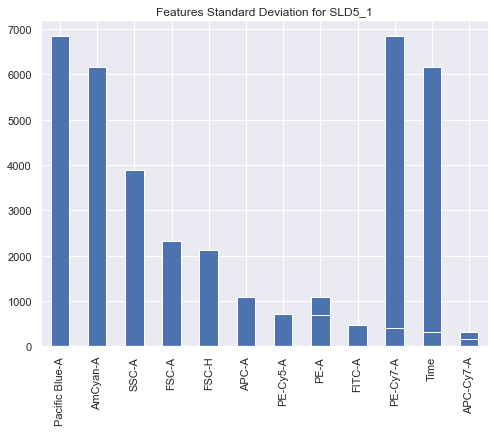

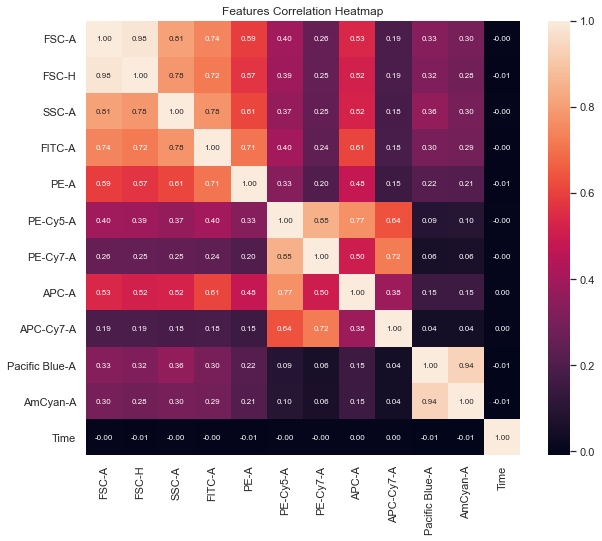

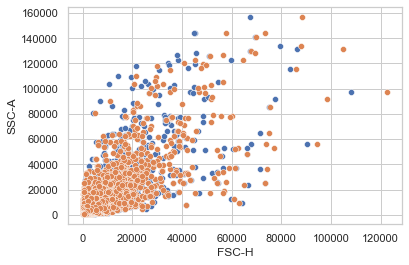

In [14]:
'''
 Function to plot different plots for a particular sample from the given samples
 Sample should in format -- sampleDX_1 as CHD1_1, CHD2_1
'''
def plot(sample, data):
    print('First five rows of sample fcs file -->')
    random_sample = random.choice(list(data.keys()))
    random_fcs_sample = data[random_sample]
    print(random_fcs_sample.head())
    
    # Printing Channels present in each fcs file
    print('Channels of the file are: ', channels)
    
    # Plotting and comparing the standard deviation of each of the input features:
    random_fcs_sample[features].std().plot(kind='bar', figsize=(8,6), title=f"Features Standard Deviation for {random_sample}")
    
    # Plotting the hist data in non-increasing order 

    features_highest_variance = random_fcs_sample[features].std().sort_values(ascending=False)
    features_highest_variance.plot(kind = 'bar')
    
    #Checking data colinearity via heatmap

    cm = np.corrcoef(random_fcs_sample[features].values.T)
    sns.set(font_scale=1.0)
    fig = plt.figure(figsize=(10, 8))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=features, xticklabels=features)
    plt.title('Features Correlation Heatmap')
    plt.show()
    
    corr = pd.DataFrame(data[sample]).corr()
    corr.style.background_gradient(cmap='coolwarm')

    sns.set(style='whitegrid')
    sns.scatterplot(x='FSC-H',y='SSC-A',data=random_fcs_sample)
    
    sns.set(style='whitegrid')
    sns.scatterplot(x='FSC-A',y='SSC-A',data=random_fcs_sample)
    plt.show()

plot('CHD1_1', data)

# Scatter/Dot Plots:

# Histogram:

<AxesSubplot:xlabel='FITC-A', ylabel='Count'>

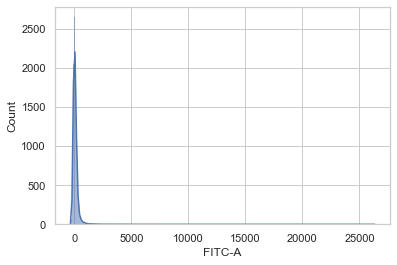

In [13]:
sns.histplot(random_fcs_sample['FITC-A'],kde='False')

<AxesSubplot:xlabel='PE-Cy5-A', ylabel='Count'>

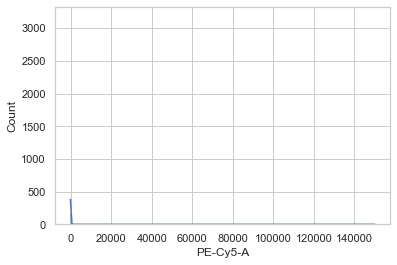

In [16]:
sns.histplot(random_fcs_sample['PE-Cy5-A'],kde='False')

<AxesSubplot:xlabel='PE-Cy7-A', ylabel='Count'>

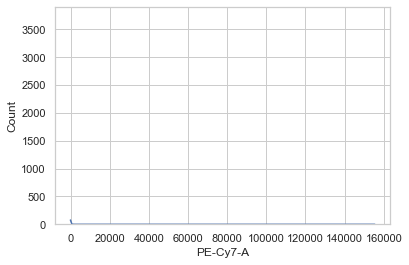

In [17]:
sns.histplot(random_fcs_sample['PE-Cy7-A'],kde='False')

# Contour Plots:

KeyboardInterrupt: 

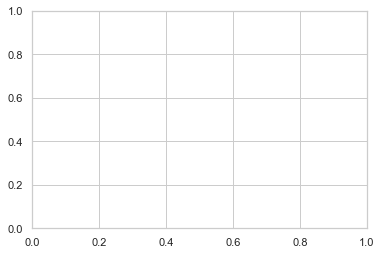

In [23]:
sns.kdeplot(x='F
            SC-A',y='SSC-A',data=random_fcs_sample)
plt.figure(figsize=(25,25))

In [ ]:
sns.kdeplot(x='FSC-A',y='AmCyan-A',data=random_fcs_sample)
plt.figure(figsize=(25,25))

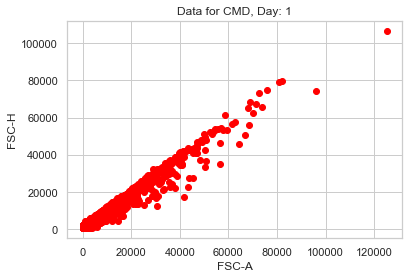

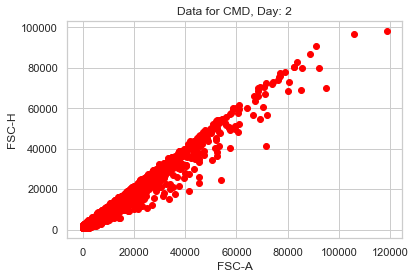

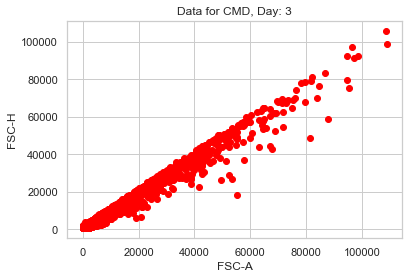

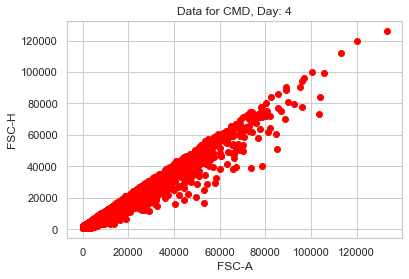

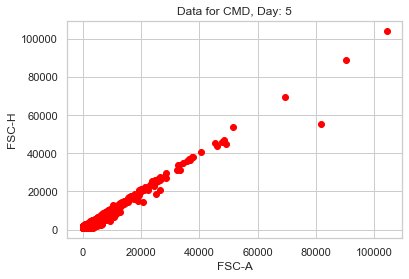

[None, None, None, None, None]

In [16]:
# Data Presentation
# Plots data for a sample from day 1 to da 5
# Direct plot can be use to conclude effect of antibiotic perturbation on methane production

def plot_sample_data(data, key, day = 1):
    key = key[:3]
    plot = pd.concat([data[key+str(day)+'_'+str(i)] for i in range(1,4)])
    plt.scatter(plot['FSC-A'],plot['FSC-H'], color = 'red')
    plt.xlabel('FSC-A')
    plt.ylabel('FSC-H')
    plt.title(f'Data for {key}, Day: {day}')
    plt.show()
    

[plot_sample_data(data, 'CMD',i) for i in range(1,6)]

(1499906, 12)


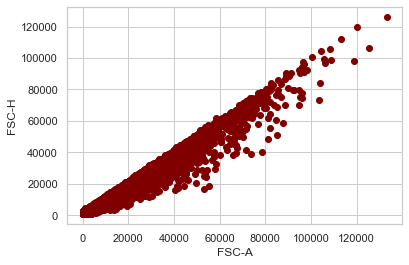

In [15]:
# function to plot combined data of all days(1-5) for a particular sample in one chart

def plot_sample(data, key):
    key = key[:3]
    original = pd.DataFrame()
    for day in range(1,6):
        l = pd.concat([data[key+str(day)+'_'+str(i)] for i in range(1,4)], axis = 0)
        original = pd.concat([original, l])
    plot = original
    print(plot.shape)
    plt.scatter(plot['FSC-A'],plot['FSC-H'], color = 'maroon')
    plt.xlabel('FSC-A')
    plt.ylabel('FSC-H')
    plt.show()

plot_sample(data,'CMD')

In [16]:
#concatenating the dataframes of all triplicates -->
def triplicates_combined(data = data):
    deta = {}
    for key in data.keys():
        deta[key[:4]]= pd.concat([data[key[:4]+'_1'],data[key[:4]+'_2'],data[key[:4]+'_3']],axis=0)
    return deta

### KMeans with feature vector of length 3

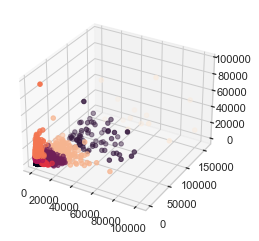

In [17]:
# Running Clustering with feature vector of size 3 in place of 3000 feature vector

num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['FSC-A','SSC-A','AmCyan-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['FSC-A'],sample['SSC-A'],sample['AmCyan-A'],c = klabels) 

plt.show()


## Intracluster Analysis

In [17]:
# K - means clustering with 3000 feature vector for all triplicates for one day -->

# triplicates_combined contains df with triplicates data in single df for each of the samples from d1 to d5
deta = triplicates_combined()

def k_means_(num_clusters = 7, data = deta, samp = random.choice(list(deta.keys()))):
    sample = data[samp][['FSC-A','SSC-A','AmCyan-A']]
    sample_vectors = np.array([[]])
    # Selecting 3000 vectors to make a matrix of 300 * 3000
    for i in range(300):
        vector = sample.sample(n = 1000).to_numpy().flatten()
        sample_vectors = np.append(sample_vectors, [vector])
    sample_vectors = np.reshape(sample_vectors, (300,3000))
    
    #Using KMeans to make given num of clusters and finally return 300 vectors with the predicted labels
    kmean = KMeans(n_clusters = num_clusters).fit(sample_vectors)
    kmean.predict(sample_vectors)
    labels = kmean.labels_
    
    cluster_count = {}
    # Finding the cluster with highest number of sample vectors of an antibiotic for that day
    for cn in range(num_clusters):
        cluster_count[cn] = sum([i == cn for i in labels])
    
    cn_ = max(cluster_count, key = cluster_count.get)
    sample_vectors = sample_vectors[[i == cn_ for i in labels]]
    
    # Removed the outliers by taking highest number of samples from biggest cluster
    lb = [samp + '-' + str(label) for label in labels if label == cn_]
    
    return pd.DataFrame(sample_vectors), pd.DataFrame(lb), cn_

def get_data(num_clusters = 8, data = deta, sample = random.choice(list(deta.keys()))):
    sd = pd.DataFrame()
    labels = pd.DataFrame()
    for day in range(1,6):
        if sample !='IN':
            samp = sample + 'D' + str(day)
            an,lb,_ = k_means_(num_clusters, data = deta, samp = samp)
            sd = pd.concat([sd, an])
            labels = pd.concat([labels, lb])
    
    labels.reset_index(drop=True, inplace=True)
    if len(labels) > 0:
        labels = pd.DataFrame((labels))
    return sd, labels


# Above function returns vectors set of major cluster from day 1 to day 5 to around ~1300 Vectors


In [18]:
def allData(deta = deta):
    finalData = pd.DataFrame()
    labels = pd.DataFrame()

    unique_samples = list(set([key[:2] for key in deta.keys()]))
    for key in unique_samples:
        a, b = total_data(7, deta, key)
        finalData = pd.concat([finalData,a ], axis = 0)
        labels = pd.concat([labels, b])
    return finalData, labels

# lb has 54 classes with each class referring to each different daily sample
#lb = LabelEncoder().fit_transform(labels)
    
# Final data is the vector collection 3000 feature vectors from the major cluster from each of the samples

In [19]:
a,b = get_data(7, deta, 'PC')
c,d = get_data(7, deta, 'CH')

In [20]:
b = transform_y(b)

In [22]:
model, scores = logistic_regression(a, b)
#define metrics
model.fit(a,b)
y_pred_proba = model.predict_proba(c)[::,1]



NameError: name 'logistic_regression' is not defined

In [31]:
fpr, tpr, _ = metrics.roc_curve(d,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'd' is not defined

In [114]:
xgb(a,b)

Accuracy: 61.80%


0.6179775280898876

In [115]:
lasso(a,b)

[0 3 1 0 1 0 3 4 2 2 4 0 0 3 3 3 4 3 1 2 0 2 0 2 0 1 4 3 0 3 2 0 0 4 0 1 3
 4 1 2 3 2 4 4 3 3 4 2 0 0 3 3 2 3 2 1 0 1 4 0 0 2 2 1 2 4 0 4 3 2 2 2 2 0
 0 2 1 0 0 3 4 4 1 3 3 4 0 0 2 0 3 1 2 3 0 0 2 1 0 2 2 3 0 0 2 4 3 0 3 3 1
 3 0 1 3 3 4 0 4 0 1 3 1 1 2 1 2 3 0 0 3 2 2 1 1 3 2 2 4 0 0 0 0 1 1 4 0 2
 1 2 2 2 4 3 0 2 4 0 0 2 0 1 3 0 0 2 0 0 0 3 2 2 4 2 0 1 0 0 3 3 4 4 1 0 4
 1 3 1 3 2 4 2 1 4 3 0 1 0 3 1 2 3 1 1 1 3 4 0 1 1 2 0 4 3 1 0 3 1 3 0 1 0
 1 2 2 2 2 2 1 0 3 4 3 2 3 0 3 4 3 3 2 2 2 1 2 4 3 1 0 4 0 2 2 1 2 0 3 3 2
 2 1 0 3 1 1 3 3 1 3 4 0 0 4 3 2 4 0 0 3 4 0 0 1 2 3 0 0 3 0 4 2 1 0 0 4 2
 3 0 2 2 1 2 4 0 4 4 1 2 2 3 4 1 2 0 0 2 0 4 3 1 1 0 4 3 4 4 4 4 2 0 4 4 2
 2]
MAPE value:  87.1125611745514
Accuracy of Lasso Regression: 12.89%.


12.887438825448598

In [116]:
m, conf_mat = naiveBayes(a,b)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished


Text(30.5, 0.5, 'Predicted label')

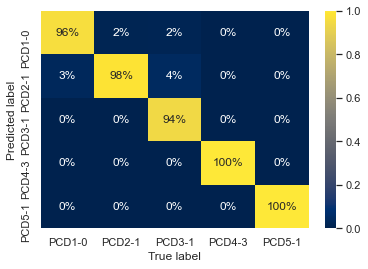

In [117]:
# Plot the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=labels, yticklabels=labels)
plt.xlabel("True label")
plt.ylabel("Predicted label")



{'whiskers': [<matplotlib.lines.Line2D at 0x1fa4621cdc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa4622b520>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa4621ca30>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa4622bc40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa4622bfd0>],
 'means': []}

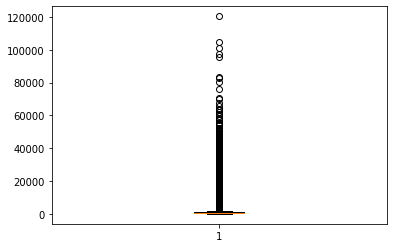

In [26]:
plt.boxplot(deta['CHD1'][['FSC-A']])

{'whiskers': [<matplotlib.lines.Line2D at 0x1fa3ea8f820>,
 'caps': [<matplotlib.lines.Line2D at 0x1fa3ea89970>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fa3ea8f070>],
 'medians': [<matplotlib.lines.Line2D at 0x1fa3ea89040>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fa3eaf4070>],
 'means': []}

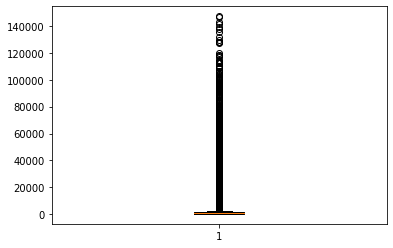

In [24]:
plt.boxplot(deta['CHD1'][['SSC-A']])

## Intercluster Analysis

In [26]:
# deta2 is a dictionary with each column containing all the events from d1 to d5 of triplicates combined 

deta2 = {}
for key in deta.keys():
    try:
      deta2[key[:-2]] = pd.concat([deta[key[:-2] + 'D' + str(i)] for i in range(1,6)])
    except KeyError:
      deta2[key] = deta[key]

for key in deta2.keys():
  print(key, deta2[key].shape)

NameError: name 'deta' is not defined

In [19]:
deta2

NameError: name 'deta2' is not defined

In [143]:
deta3 = deta2.copy()
for key in deta3.keys():
  deta3[key] = prepData(deta3[key])[0]

deta3


{'CH': array([[-0.23449196, -0.03396695,  0.00176173, ..., -0.16685331,
         -0.19092488, -0.8047867 ],
        [-0.16597676, -0.13209549,  0.01556854, ...,  0.05290031,
         -0.05273224, -0.7402512 ],
        [-0.1117579 , -0.06850683, -0.04069235, ...,  0.26345414,
         -0.03926691, -0.4938854 ],
        ...,
        [-0.24750155, -0.16892718, -0.2431435 , ..., -0.27738917,
         -0.23408021,  0.5222478 ],
        [-0.15180852, -0.15186879, -0.25078148, ..., -0.17012732,
         -0.29362133,  0.68005395],
        [-0.01321784, -0.10307054,  0.32988855, ..., -0.03762998,
          0.2510761 ,  0.41282353]], dtype=float32),
 'CL': array([[ 0.00361875, -0.05566327, -0.14661415, ..., -0.12072866,
         -0.18818438, -0.86201835],
        [-0.01311734, -0.07458203, -0.06917766, ..., -0.14967147,
         -0.19468814, -0.8391847 ],
        [ 0.02968165, -0.05097588, -0.1249475 , ..., -0.14628243,
         -0.16390625, -0.68961054],
        ...,
        [-0.14449732, -0.10

## Using all the sample data in a single run:

## KMeans without PCA:

In [27]:
#  K - means clustering with 3000 feature vector for all triplicates for all day1 to day5 -->

def k_means(num_clusters = 8, data = deta2, samp = random.choice(list(deta2.keys())), to_sample = 1500):
    sample = data[samp][['FSC-A','SSC-A','AmCyan-A']]
    sample_vectors = np.array([[]])
    for i in range(to_sample):
      # Sampling each feature vector with 1000 events chosen combined from 3*15*100,000 events dataset
      vector = sample.sample(n = 1000).to_numpy().flatten()
      sample_vectors = np.append(sample_vectors, [vector])
    sample_vectors = np.reshape(sample_vectors, (1500,3000))
    kmean = KMeans(n_clusters = num_clusters).fit(sample_vectors)
    kmean.predict(sample_vectors)
    labels = kmean.labels_

    lb = [samp + '-' + str(label) for label in labels]
    return sample_vectors, lb

## KMeans with PCA with 3 components:

In [119]:
# PCA dimns reduction to 3 dimensions with K - means clustering with 3000 feature vector for all triplicates for all day1 to day5 -->

def k_means_with_pca(num_clusters = 7, data = deta2, samp = random.choice(list(deta2.keys())), to_sample = 1500):
    sample = data[samp][['FSC-A','SSC-A','AmCyan-A']]
    sample_vectors = np.array([[]])
    for i in range(to_sample):
      # Sampling each feature vector with 1000 events chosen combined from 3*15*100,000 events dataset
      vector = sample.sample(n = 1000).to_numpy().flatten()
      sample_vectors = np.append(sample_vectors, [vector])
    sample_vectors = np.reshape(sample_vectors, (1500,3000))
    
    # Using PCA for sampling the 3000 features to 3 features(Principal Components)
    sample_vectors_ = PCA(n_components = 100).fit_transform(sample_vectors)

    kmean = KMeans(n_clusters = num_clusters).fit(sample_vectors_)
    kmean.predict(sample_vectors_)
    labels = kmean.labels_

    lb = [samp + '-' + str(label) for label in labels]
    return pd.DataFrame(sample_vectors_), lb




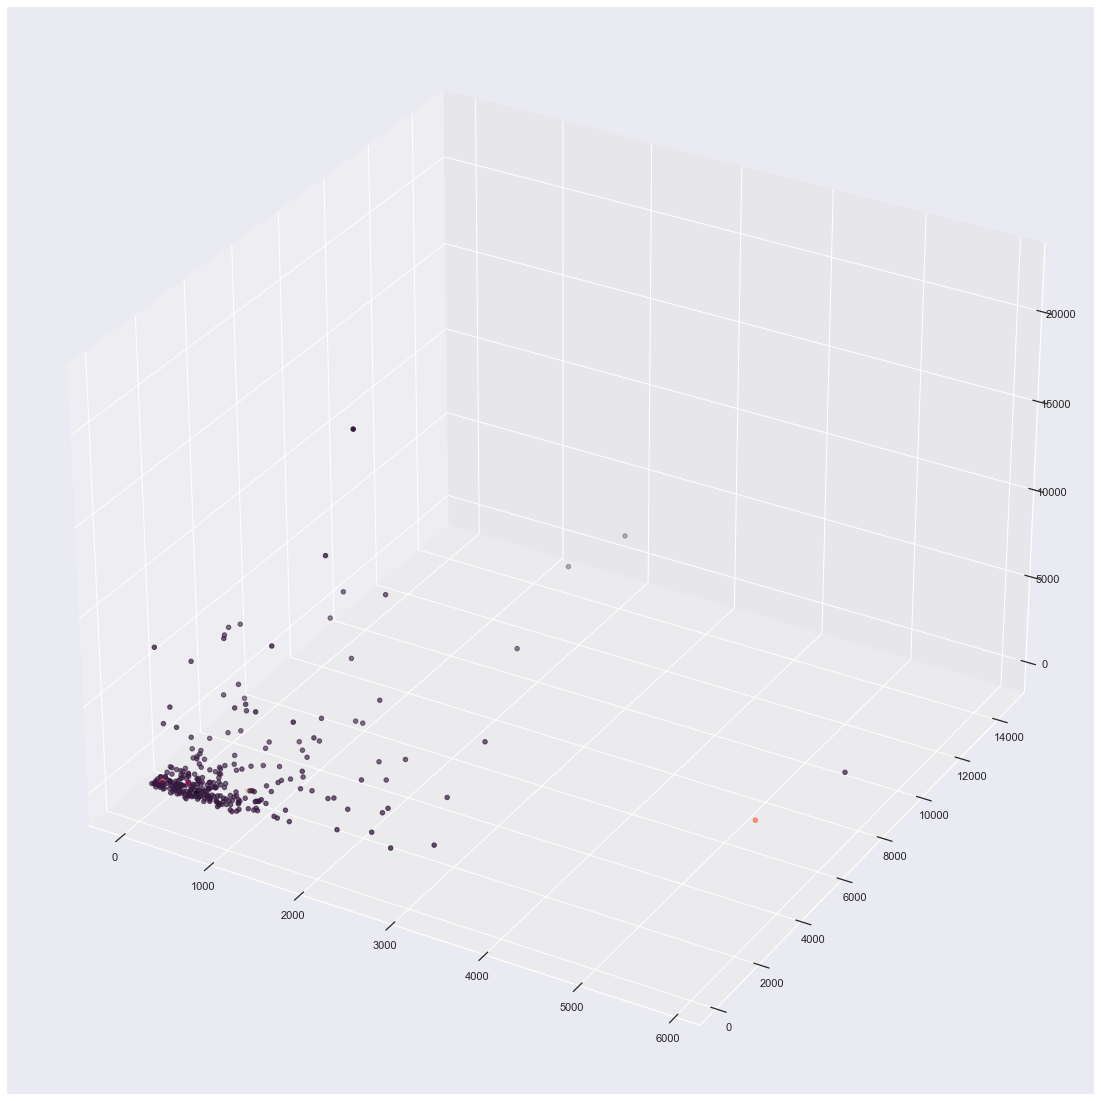

In [95]:
# <Testing> KMeans Clustering with Low concentration of  
a,b = k_means(data = deta2, samp = 'CL')

# Visualizing the above->

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111, projection='3d')
a = pd.DataFrame(a)
ax.scatter(a.iloc[:,0],a.iloc[:,1],a.iloc[:,2],c = LabelEncoder().fit_transform(b)) 

plt.show() 


In [37]:
deta2 

{'CH':             FSC-A  FSC-H        SSC-A      FITC-A        PE-A    PE-Cy5-A  \
 0       96.800003  995.0  1552.320068    2.970000   63.360001   70.290001   
 1      252.800003  707.0  1641.420044   87.120003   38.610001   59.400002   
 2      248.000000  791.0  1152.359985  -89.099998 -523.710022    1.980000   
 3      229.600006  827.0   708.840027   58.410000    1.980000   39.599998   
 4      289.600006  800.0  1036.530029   26.730000 -621.720032   53.459999   
 ...           ...    ...          ...         ...         ...         ...   
 99995  416.800018  892.0   414.809998  183.150009 -175.229996  -72.270004   
 99996  288.800018  831.0  1428.570068   51.480000  365.309998  -56.430000   
 99997  180.800003  716.0   356.399994  200.970001 -140.580002  109.889999   
 99998  494.399994  830.0   602.910034  100.980003 -141.570007    4.950000   
 99999  733.600037  800.0  3576.870117   91.080002  533.609985  215.820007   
 
         PE-Cy7-A        APC-A   APC-Cy7-A  Pacific Blue

In [25]:
# Combining the dataset of all samples to make final_df of shape - (11*1500, no_columns)
final_df = pd.DataFrame()
for key in deta2.keys():
  if key!='IND0' :
    v,lb = k_means_with_pca(data = deta2, samp = key)
    p = pd.DataFrame(v)
    p['labels'] = lb
    final_df = pd.concat([final_df,p], axis = 0)

labels = final_df['labels']
final_df.drop(['labels'], axis = 1)



NameError: name 'deta2' is not defined

In [121]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,labels
0,6110.842384,-1019.534986,-3366.262887,-1379.093402,2527.368512,-1195.304035,2659.644562,-12546.432480,3290.232461,3741.207193,...,13055.034382,4207.385914,1449.845519,-2467.348612,1914.266050,9230.690650,-5754.716997,-487.651888,-8946.693087,CH-6
1,-3522.481329,-5083.863863,-4404.465552,-5322.998797,-16746.929045,-26369.621070,26873.768164,19810.263418,16966.020784,8701.932723,...,14205.451197,-17806.447182,15444.326355,7437.027132,1108.300654,-8992.534803,-1243.186357,-15165.725451,1742.119324,CH-6
2,-3475.752456,-4172.885899,-2390.806546,-1570.823772,4175.935868,-3080.376855,-1913.956952,-4749.656049,-5221.960701,-5522.794840,...,1596.833951,-3484.607031,-7288.873262,-8164.524488,-634.967704,-2685.438870,3080.417968,1699.140872,6519.963852,CH-4
3,-1894.463008,-3373.229163,-3141.231092,-2205.232294,468.716578,-5676.838261,-6973.272094,-11017.610333,13772.723354,9416.173510,...,455.182801,1223.582762,-2176.728853,-1785.656565,-1553.006632,-8351.267469,4019.276987,-5785.617524,-11638.243760,CH-6
4,6570.220510,-101.439057,-2596.273587,-2003.177078,6031.794116,-942.712414,1507.242474,5901.927184,-5499.188688,-4332.758333,...,9075.717449,5467.794983,-8553.797928,7784.743432,-12258.150343,-8664.178946,-13506.497948,9117.111763,5874.360670,CH-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-4900.621427,2104.524982,-1277.018890,-1383.942481,1994.159985,5047.250567,-3188.006588,4644.168254,-1565.547061,5957.413321,...,1856.725711,1723.428794,-1544.805228,3262.973656,3000.140013,1958.574983,-159.142755,-7253.023307,-512.724551,TM-3
1496,8781.027983,-110.237542,7259.775463,16817.594513,3576.090166,-3336.238977,718.252082,-1598.077613,1823.366803,4501.971366,...,881.740472,2824.221309,-12177.114369,-8225.670116,-3176.975091,463.865003,6771.713002,-4181.281963,2951.959948,TM-6
1497,-3395.241375,-2611.352747,-2055.339791,-4827.632779,17036.516799,2781.126916,-10664.207015,-12534.659830,3224.068921,-2169.756739,...,4254.988469,-4247.729540,-74.378150,-12857.138320,-5573.143927,282.919239,4955.964297,-6754.665475,-2913.092575,TM-6
1498,982.568561,-1648.600846,1034.927093,-7247.770664,15264.575672,-5007.930882,-3939.154424,-8225.926973,-3090.568807,-4044.116886,...,4018.170717,331.782729,3062.803489,-1207.653545,-2173.668740,774.532124,-3774.629854,-3593.534282,5412.647692,TM-3


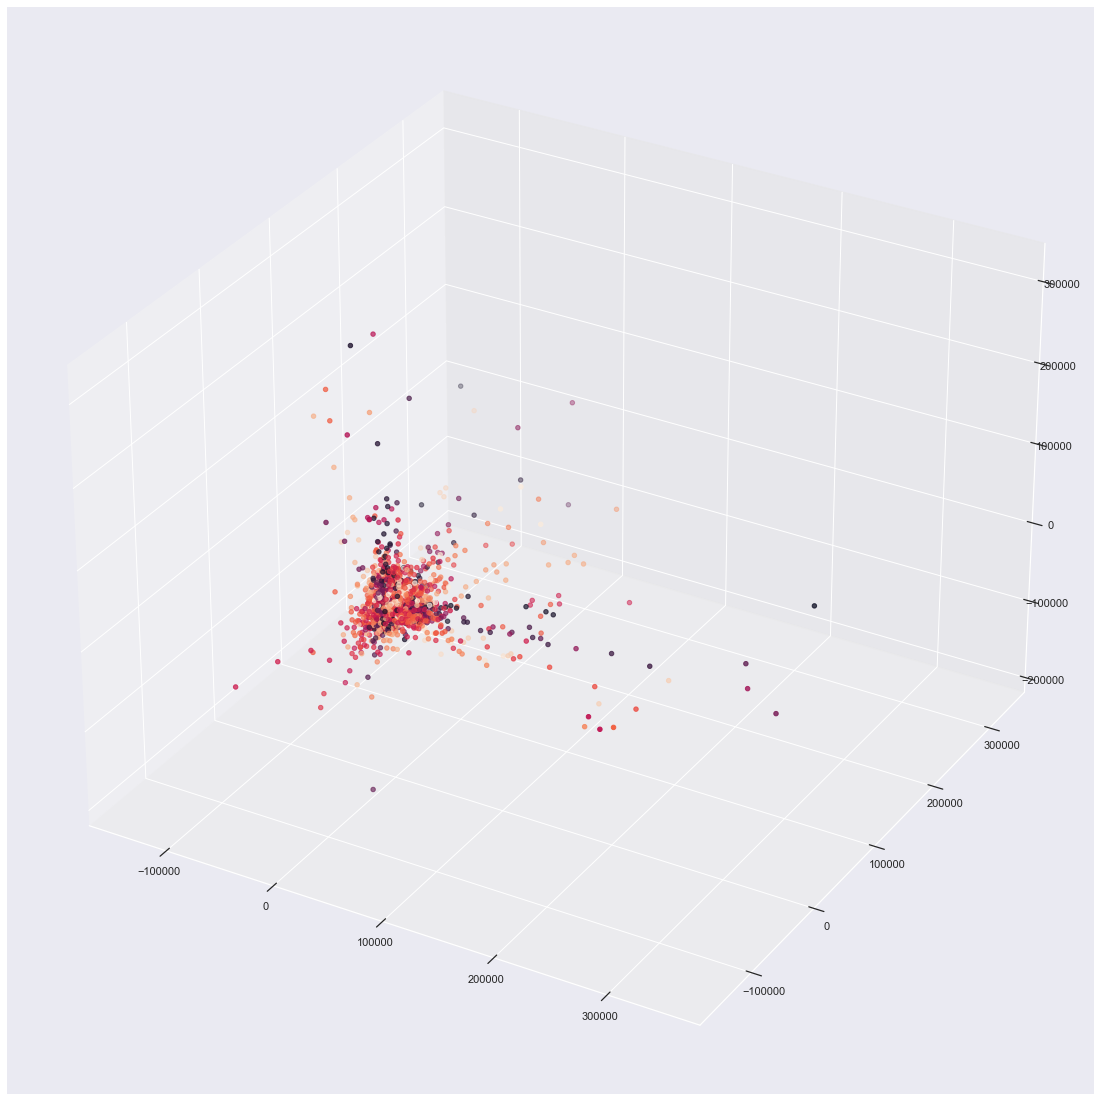

In [122]:
# Visualizing the above(used only when feature vector of length 3 was used)->

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_df.iloc[:,0],final_df.iloc[:,1],final_df.iloc[:,2],c = LabelEncoder().fit_transform(labels)) 

plt.show() 

## Using Hierarchial Clustering



In [48]:
from sklearn.cluster import AgglomerativeClustering


model = AgglomerativeClustering(n_clusters=4, affinity='euclidean')
model.fit(deta['CHD1'])

MemoryError: Unable to allocate 335. GiB for an array with shape (44999850000,) and data type float64

In [44]:
deta

{'CHD1':              FSC-A   FSC-H        SSC-A      FITC-A        PE-A     PE-Cy5-A  \
 0        96.800003   995.0  1552.320068    2.970000   63.360001    70.290001   
 1       252.800003   707.0  1641.420044   87.120003   38.610001    59.400002   
 2       248.000000   791.0  1152.359985  -89.099998 -523.710022     1.980000   
 3       229.600006   827.0   708.840027   58.410000    1.980000    39.599998   
 4       289.600006   800.0  1036.530029   26.730000 -621.720032    53.459999   
 ...            ...     ...          ...         ...         ...          ...   
 99995   453.600006   691.0  1041.479980  133.649994  -63.360001   -45.540001   
 99996   358.399994   816.0  1626.570068  -47.520000  146.520004  1256.310059   
 99997  2806.400146  2898.0  1939.410034   -4.950000  331.649994   -33.660000   
 99998   798.400024  1623.0  1729.530029 -180.180008 -955.350037    10.890000   
 99999   368.000000   738.0  1073.160034   76.230003 -200.970001   -13.860001   
 
          PE-Cy7-A

# Clustering via DBSCAN:

In [21]:
# Vector Dataset Creation
deta = triplicates_combined()

pre_final_df = pd.DataFrame() 
for key in deta.keys():
    key = key[:-2]
    pre_final_df[key] = pd.concat([pd.DataFrame(deta[key + 'D' + str(i)]) for i in range(1,6)])


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [35]:
    
def gaussian_mm(x, param=None):
    # training gaussian mixture model 
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=5)
    gmm.fit(x)

    #predictions from gmm
    labels = gmm.predict(x)
    frame = pd.DataFrame(x)
    frame['cluster'] = labels
    
    return frame

In [37]:
ff = gaussian_mm(deta['CHD1'].values)

,0,1,2,3,4,5,6,7,8,9,10,11,cluster
0,96.800003,995.0,1552.320068,2.970000,63.360001,70.290001,41.580002,-386.399994,-81.599998,95.920006,135.160004,45.900002,4
1,252.800003,707.0,1641.420044,87.120003,38.610001,59.400002,11.880000,-368.000000,225.600006,1192.460083,747.740051,45.900002,2
2,248.000000,791.0,1152.359985,-89.099998,-523.710022,1.980000,80.190002,1309.599976,-161.600006,3009.489990,717.220032,45.900002,2
3,229.600006,827.0,708.840027,58.410000,1.980000,39.599998,-33.660000,-232.000000,56.000000,17.440001,81.750000,45.900002,0
4,289.600006,800.0,1036.530029,26.730000,-621.720032,53.459999,-57.420002,-209.600006,-21.600000,43.600002,-25.070002,46.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,453.600006,691.0,1041.479980,133.649994,-63.360001,-45.540001,-50.490002,356.000000,-135.199997,75.209999,151.510010,1202.199951,0
299996,358.399994,816.0,1626.570068,-47.520000,146.520004,1256.310059,290.070007,4705.600098,-116.800003,98.100006,1025.690063,1202.199951,3
299997,2806.400146,2898.0,1939.410034,-4.950000,331.649994,-33.660000,-19.799999,496.000000,53.600002,324.820007,231.080002,1202.199951,1
299998,798.400024,1623.0,1729.530029,-180.180008,-955.350037,10.890000,-44.549999,128.000000,36.799999,402.210022,664.900024,1202.300049,1


# Classification using different ML algorithms:

In [22]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import ELU
import os
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Generation of Neural Network model

In [23]:
def getModel (row_length, num_class):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim = row_length))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout (0.3))

    model.add(Dense(num_class, activation='softmax'))

    model.compile (loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics=['accuracy'])
    return model


In [24]:
# Function to get a model of a particular type 

def get_model(model):   
    if model == 'svm':
        param_grid = [{"kernel": ["linear","rbf"],"gamma":[1, 0.1, 0.01],"C":[0.001, 0.1, 1]}]
        svc = SVC(probability = True)
        return param_grid, svc
    elif model == 'randomForestClassifier':
        param_grid = [{'max_depth': [ 25,50,100], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10] , 
                       'n_estimators': [600, 800, 1200]  }]
        rfc = RandomForestClassifier(random_state=42)
        return param_grid, rfc
    elif model == "naiveBayes":
        param_grid = [ ]
        gnb = GaussianNB()
        return param_grid, gnb
    elif model == 'gbm':
        param_grid = [{"learning_rate": [0.1, 1, 10], "min_samples_split": [300, 400, 100],
                      "max_depth":[5,10, 15], "n_estimators":[300, 400, 100] }]
        gbm = GradientBoostingClassifier()
        return param_grid, gbm
    elif model == 'xgb':
        param_grid = [{'gamma': [0, 1, 2], 'subsample': [0.6, 0.8, 1.0], 'n_estimators': [100, 200, 500],       
                      'max_depth': [1, 2, 3], 'learning_rate': [10,3,1,0.1, 0.01]}]
        xgb = XGBClassifier(nthread =4,   #when use hyperthread, xgboost may become slower
             #objective ='binary:logistic'  , min_child_weight= 11, silent = 1, colsample_bytree = 0.7, 
              seed =1337)
        return param_grid, xgb
    elif model == 'dTree':
        param_grid = [{"criterion": ['gini', 'entropy'], 'max_depth': [10, 50, 100], 'min_samples_split': [10,50,100],  'min_samples_leaf': [10,50,100]} ]
        dec = DecisionTreeClassifier()
        return param_grid, dec
    elif model == 'nn':
        param_grid = [ ]
        nn = getModel(row_len, num_classes)
        return param_grid, nn
    elif model == 'LogisticRegression':
        param_grid = [{"penalty":['l2'],"C":[ 10, 1.0, 0.1, 0.01] , "solver":['saga']}]
        logreg = LogisticRegression()
        return param_grid, logreg
    elif model == 'LassoRegression':
        lasso_model = Lasso()
        param_grid = [{'alpha': [0.1, 0.2, 0.5, 0.8, 1.0]}]
        return param_grid, lsreg
    elif model == 'lgb':
        param_grid = {
                  'num_leaves': [31, 127],
                  'reg_alpha': [0.1, 0.5],
                  'min_data_in_leaf': [30, 300, 400],
                  'lambda_l1': [0, 1, 1.5],
                   'lambda_l2': [0, 1]}
        lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01)
        return param_grid, lgb_estimator
    else:
        assert 0, "Choose one from : " + "'svm', 'randomForestClassifier', 'naiveBayes', 'gbm', 'xgb','nn'" 

In [25]:
Classification = ['svm', 'randomForestClassifier', 'naiveBayes', 'gbm', 'xgb','nn', 'LassoRegression', 'dTree','LogisticRegression']

## Model training witout gridsearch

In [26]:
# Function to train data when gridsearch is not used for model
from sklearn.model_selection import train_test_split

def training(classifier, X, y, label_names):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    train_acc = accuracy_score(y_train_pred, y_train,)
    test_acc = accuracy_score(y_test_pred, y_test)
    
    # Output Confusion Matrix of the testset
    conf_matrix = confusion_matrix(y_test_pred, y_test)
    sns.heatmap(conf_matrix, annot=True)
    plt.show()
    
    target_names = label_names
    print(metrics.classification_report(y_test, y_test_pred, target_names=target_names))

    y_prob = classifier.predict_proba(X_test)     


    '''
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                      average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                         average="weighted")
    '''
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                         average="weighted")
    '''
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    '''
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))



    fpr = {}
    tpr = {}
    thresh ={}

    n_class = len(label_names)

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=i)


    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    
    return train_acc, test_acc

In [27]:
# function to run grid search cv and stratified kfold on the model
def run_cv(model, X, y,label_names,param_grid,outer_folds = 5):
    i=1
    kf = StratifiedKFold(n_splits=outer_folds,random_state=1,shuffle=True)
    train_acc = []
    validation_acc = [] 
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.15)

        
    for train_index,test_index in kf.split(X_tr,y_tr):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = X_tr.iloc[train_index],X_tr.iloc[test_index]
        ytr,yvl = y_tr[train_index],y_tr[test_index]
        
        model_grid = GridSearchCV( model, param_grid, cv=5,scoring=None)
        model1 = OneVsRestClassifier(model_grid)
        model1.fit(xtr, ytr)
        
        train_pred = model1.predict(xtr)
        validation_pred = model1.predict(xvl)
        test_pred = model1.predict(X_te)
        
        print('Train_accuracy_score',accuracy_score(ytr,train_pred))        
        print('Validation_accuracy_score',accuracy_score(yvl,validation_pred))
        print('Test_accuracy_score',accuracy_score(y_te, test_pred))
        
        train_acc.append(accuracy_score(ytr,train_pred))
        validation_acc.append(accuracy_score(yvl,validation_pred))        
        i+=1
        train_accuracy = train_acc
        validation_accuracy = validation_acc
        train_accuracy_mean = np.mean(train_acc)
        validation_accuracy_mean = np.mean(validation_acc)
        
        test_accuracy = accuracy_score(y_te, test_pred)
        
        # Output Confusion Matrix of the testset
        conf_matrix = metrics.confusion_matrix(y_te, test_pred)
        sns.heatmap(conf_matrix, annot=True)
        plt.show()
        
        target_names = label_names
        print(metrics.classification_report(y_te, test_pred))   # , target_names=target_names
        
        y_prob = model1.predict_proba(X_te)     
        
        
        
        #macro_roc_auc_ovo = roc_auc_score(y_te, y_prob, multi_class="ovo",
        #                                  average="macro")
        #weighted_roc_auc_ovo = roc_auc_score(y_te, y_prob, multi_class="ovo",
        #                                     average="weighted")
        macro_roc_auc_ovr = roc_auc_score(y_te, y_prob, multi_class="ovr",
                                          average="macro")
        weighted_roc_auc_ovr = roc_auc_score(y_te, y_prob, multi_class="ovr",
                                             average="weighted")
        #print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
        #      "(weighted by prevalence)"
        #      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
        print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
              "(weighted by prevalence)"
              .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

                
        
        fpr = {}
        tpr = {}
        thresh ={}
        roc_auc = {}

        n_class = len(target_names)

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_te, y_prob[:,i], pos_label=i)
            roc_auc[i] = auc(fpr[i],tpr[i])
            
        print(roc_auc)
        # plotting    
        plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
        plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
        plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
        plt.show()
        
        
        
    test_pred_final = model1.predict(X_te)
    print('Test_accuracy_score',accuracy_score(y_te, test_pred_final))
    # Output Confusion Matrix of the testset
    conf_matrix_final = metrics.confusion_matrix(y_te, test_pred_final)
    sns.heatmap(conf_matrix_final, cmap = "cividis", annot=True)
    plt.show()
        
    target_names = label_names
    print(metrics.classification_report(y_te, test_pred_final, target_names=target_names))
        
    y_prob_final = model1.predict_proba(X_te)
    
    print(y_prob_final)
    '''
    macro_roc_auc_ovo_final = roc_auc_score(y_te, y_prob_final, multi_class="ovo",
                                          average="macro")
    weighted_roc_auc_ovo_final = roc_auc_score(y_te, y_prob_final, multi_class="ovo",
                                         average="weighted")
    '''
    macro_roc_auc_ovr_final = roc_auc_score(y_te, y_prob_final, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr_final = roc_auc_score(y_te, y_prob_final, multi_class="ovr",
                                         average="weighted")
    #print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    #      "(weighted by prevalence)"
    #      .format(macro_roc_auc_ovo_final, weighted_roc_auc_ovo_final))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr_final, weighted_roc_auc_ovr_final))
    
    # roc curve for classes
    fpr_final = {}
    tpr_final = {}
    thresh_final ={}
    roc_auc_final = {}

    n_class = len(target_names)

    for i in range(n_class):    
        fpr_final[i], tpr_final[i], thresh_final[i] = roc_curve(y_te, y_prob_final[:,i], pos_label=i)
        roc_auc_final[i] = auc(fpr_final[i],tpr_final[i])
    
    print(roc_auc_final)
    # plotting    
    plt.plot(fpr_final[0], tpr_final[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
    plt.plot(fpr_final[1], tpr_final[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
    plt.plot(fpr_final[2], tpr_final[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
   
    
    
    
    return train_accuracy , validation_accuracy, train_accuracy_mean, validation_accuracy_mean, test_accuracy

In [28]:
# labels = final_df.iloc[:,-1]
# final_df = final_df.drop(['labels'], axis = 1)
a,b = get_data(7, deta, 'PC')

In [29]:
b, lb = transform_y(b)
b = b.to_numpy()

In [30]:
params, model1 = get_model('dTree')


1 of kfold 5
Train_accuracy_score 0.5692488262910798
Validation_accuracy_score 0.29107981220657275
Test_accuracy_score 0.291005291005291


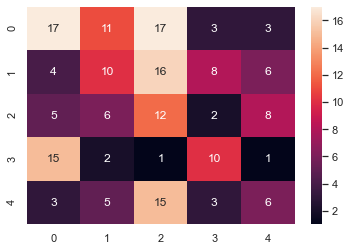

              precision    recall  f1-score   support

           0       0.39      0.33      0.36        51
           1       0.29      0.23      0.26        44
           2       0.20      0.36      0.26        33
           3       0.38      0.34      0.36        29
           4       0.25      0.19      0.21        32

    accuracy                           0.29       189
   macro avg       0.30      0.29      0.29       189
weighted avg       0.31      0.29      0.29       189

One-vs-Rest ROC AUC scores:
0.611290 (macro),
0.602833 (weighted by prevalence)
{0: 0.6101875532821824, 1: 0.5275078369905957, 2: 0.5287490287490287, 3: 0.7744612068965517, 4: 0.6155453821656051}


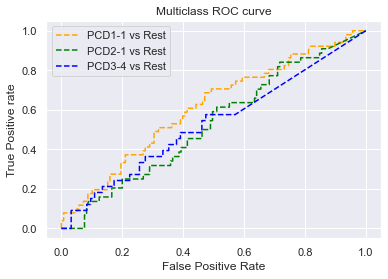


4 of kfold 5
Train_accuracy_score 0.5269953051643192
Validation_accuracy_score 0.28169014084507044
Test_accuracy_score 0.31216931216931215


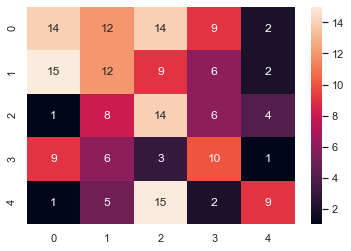

              precision    recall  f1-score   support

           0       0.35      0.27      0.31        51
           1       0.28      0.27      0.28        44
           2       0.25      0.42      0.32        33
           3       0.30      0.34      0.32        29
           4       0.50      0.28      0.36        32

    accuracy                           0.31       189
   macro avg       0.34      0.32      0.32       189
weighted avg       0.34      0.31      0.31       189

One-vs-Rest ROC AUC scores:
0.630029 (macro),
0.619421 (weighted by prevalence)
{0: 0.5822676896845694, 1: 0.559012539184953, 2: 0.5876068376068376, 3: 0.6976293103448276, 4: 0.7236265923566878}


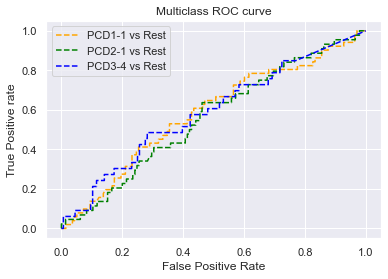


4 of kfold 5
Train_accuracy_score 0.4671361502347418
Validation_accuracy_score 0.3286384976525822
Test_accuracy_score 0.3386243386243386


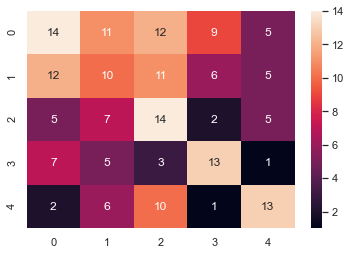

              precision    recall  f1-score   support

           0       0.35      0.27      0.31        51
           1       0.26      0.23      0.24        44
           2       0.28      0.42      0.34        33
           3       0.42      0.45      0.43        29
           4       0.45      0.41      0.43        32

    accuracy                           0.34       189
   macro avg       0.35      0.36      0.35       189
weighted avg       0.34      0.34      0.34       189

One-vs-Rest ROC AUC scores:
0.629510 (macro),
0.615286 (weighted by prevalence)
{0: 0.5755186132423984, 1: 0.5224137931034483, 2: 0.5790598290598291, 3: 0.7384698275862069, 4: 0.7320859872611465}


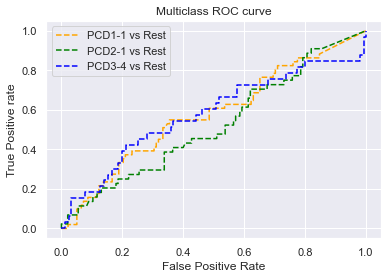


4 of kfold 5
Train_accuracy_score 0.568075117370892
Validation_accuracy_score 0.37089201877934275
Test_accuracy_score 0.31216931216931215


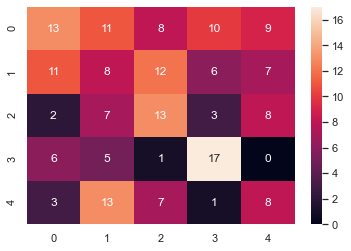

              precision    recall  f1-score   support

           0       0.37      0.25      0.30        51
           1       0.18      0.18      0.18        44
           2       0.32      0.39      0.35        33
           3       0.46      0.59      0.52        29
           4       0.25      0.25      0.25        32

    accuracy                           0.31       189
   macro avg       0.32      0.33      0.32       189
weighted avg       0.31      0.31      0.31       189

One-vs-Rest ROC AUC scores:
0.634458 (macro),
0.620464 (weighted by prevalence)
{0: 0.6155868144359192, 1: 0.47970219435736683, 2: 0.6247086247086246, 3: 0.7742456896551725, 4: 0.6780453821656051}


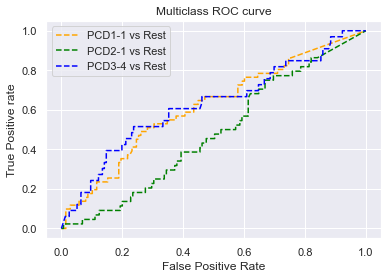


4 of kfold 5


In [ ]:
run_cv(model1, a, b, lb, params)

In [ ]:
# function to run neural network

def run_nn(model1, X, y, label_names,batch_size = 32, epochs = 500):
      
    # Train model using 5 fold cross_validation
    accs = []
    cross_val_n_splits = 5
    curr_split = 1
    skf = KFold(n_splits=cross_val_n_splits, random_state = 243, shuffle=True)
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.25)
    
    for train_index, test_index in skf.split(X_tr, y_tr):
        print(f'-----Cross Validation {curr_split}/{cross_val_n_splits}-----')
        X_train, y_train = X_tr.iloc[train_index], y_tr[train_index]
        X_test, y_test = X_tr.iloc[test_index], y_tr[test_index]
        Y_train = y_train
        Y_test = y_test
        nn_model = OneVsRestClassifier(model1)       #getModel(row_len, num_classes)
#       cp_callback = ModelCheckpoint (cp_filepath, monitor="val_acc", save_best_only=True)
        history = nn_model.fit(X_train, Y_train)
    
    y_true = np.argmax(y_te, axis = -1)
   
    y_pred = np.argmax(nn_model.predict(X_te, batch_size=1), axis=-1)
    print ("Confusion Matrix, cross val split {}".format(curr_split))
    
    # Output Confusion Matrix of the testset
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True)
    plt.show()
    
    # Plotting accuracy and validation accuracy 
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,501)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='validation accuracy')
    plt.title('Training and Validation acuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    curr_split += 1
    
    target_names = label_names
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))

    y_prob = nn_model.predict_proba(X_te)     



    macro_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo",
                                      average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))



    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = {}

    n_class = 3

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_prob[:,i], pos_label=i)


    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label= label_names[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label= label_names[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label= label_names[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

print ('----- Done -----')

In [51]:
Classification = ['svm', 'randomForestClassifier', 'naiveBayes', 'gbm', 'xgb','nn', 'LinearRegression', 'DecTree']

# Training a autoencoder

In [26]:
df_, l = total_data(7, deta, 'PC')

In [29]:
final_df = StandardScaler().fit_transform(df_)
lbs = LabelEncoder().fit_transform(l)

In [25]:
# Training an Autoencoder for anomaly detection

# Using compressive encoding via autoencoder
# Training an autoencoder-->

# Scaling the data to make it suitable for the auto-encoder
X_scaled = MinMaxScaler().fit_transform(final_df)


# Building the Input Layer
input_layer = Input(shape =(final_df.shape[1], ))
  
# Building the Encoder network
encoded = Dense(100, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation ='relu')(encoded)
  
# Building the Decoder network
decoded = Dense(12, activation ='tanh')(encoded)
decoded = Dense(25, activation ='tanh')(decoded)
decoded = Dense(50, activation ='tanh')(decoded)
decoded = Dense(100, activation ='softmax')(decoded)
  
# Building the Output Layer
output_layer = Dense(final_df.shape[1], activation ='relu')(decoded)


# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adadelta", loss ="mse")
  
# Training the Auto-encoder network
autoencoder.fit(X_scaled, X_scaled, 
                batch_size = 16, epochs = 10, 
                shuffle = True, validation_split = 0.20)

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

NameError: name 'final_df' is not defined

In [139]:
# Autoencoder P2 -->

final_df = hidden_representation.predict(X_scaled)

516/516 [==============================] - 1s 875us/step


In [140]:
final_df

array([[-0.05057386,  0.70546526,  0.4717596 , ..., -0.5412113 ,
        -0.44630507,  0.86211383],
       [ 0.05081545,  0.70257443,  0.44101545, ..., -0.62394506,
        -0.3952314 ,  0.8946018 ],
       [-0.03810772,  0.6769634 ,  0.5348599 , ..., -0.5183734 ,
        -0.4212776 ,  0.8275243 ],
       ...,
       [-0.03057418,  0.69563323,  0.49732915, ..., -0.5346057 ,
        -0.46065843,  0.86639726],
       [-0.05255631,  0.7169135 ,  0.5294302 , ..., -0.53417754,
        -0.450874  ,  0.8701344 ],
       [-0.01537817,  0.71921563,  0.47633153, ..., -0.52981   ,
        -0.45182133,  0.885187  ]], dtype=float32)

# Logistic Regression

In [26]:
# Using Logistic Regression for Multi-Class Classification ->

# When logistic regression is used for multi-class classification, it basically uses binary classification multiple times with a multinomial probability distribution as it is not made for multi-class classification
# So called One vs Rest approach is used in such classification

from statistics import mean, stdev
def logistic_regression(x, y):
  # defined the multinomial logistic regression model
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate the model and collect the scores
  n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report the model performance
  # print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), stdev(n_scores)))
  return model, n_scores

# df_, l = total_data(8, deta, 'PC')
# logistic_regression(df_, l)

# Lasso Regression

In [70]:
# Lasso Regression

def lasso(X, Y):
    def MAPE(Y_actual , Y_predicted):
        return np.mean(np.abs(Y_actual-Y_predicted))*100/np.mean(Y_actual)
    if Y[0] is not int:
        Y = LabelEncoder().fit_transform(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X.values, Y, train_size = 0.75)
    lasso_model = Lasso(alpha=1.0)
    lasso=lasso_model.fit(X_train , Y_train)
    lasso_predict = [round(i) for i in lasso.predict(X_test)]
    print(Y_test)
    Lasso_MAPE = MAPE(Y_test,lasso_predict)
    print("MAPE value: ",Lasso_MAPE)
    Accuracy = 100 - Lasso_MAPE
    print('Accuracy of Lasso Regression: {:0.2f}%.'.format(Accuracy))
    return Accuracy

lasso(df_, l)

[0 3 0 2 4 2 1 0 0 4 2 0 4 4 0 4 2 3 1 2 4 3 2 2 4 0 4 2 1 1 4 0 0 0 0 2 2
 1 3 0 2 2 3 0 1 4 1 1 4 4 4 1 2 4 4 2 1 2 1 3 0 0 2 1 3 1 4 4 0 4 3 0 0 0
 4 0 4 3 2 2 4 1 0 2 1 4 3 0 4 2 4 1 0 0 3 4 3 3 2 4 1 4 3 1 4 2 3 2 2 4 1
 2 2 2 0 2 1 0 0 1 4 4 0 0 0 2 0 2 3 2 0 2 4 4 3 1 1 4 0 4 2 3 2 4 2 3 3 4
 4 4 0 4 0 4 4 3 4 4 1 4 3 2 1 4 3 1 4 0 1 4 1 1 4 4 1 0 4 1 3 2 4 1 1 1 1
 3 0 2 4 3 1 4 3 0 2 2 2 3 2 3 2 3 1 4 2 4 0 1 2 3 1 0 3 3 0 3 0 1 2 1 1 3
 2 3 2 3 4 2 4 3 2 0 1 1 3 2 2 1 2 2 3 4 1 2 4 4 3 3 1 4 3 1 0 0 0 1 1 1 3
 3 1 3 4 4 4 3 4 3 0 1 2 0 4 2 0 3 3 0 0 4 0 1 1 4 4 0 0 2 2 1 0 2 3 3 2 0
 1 0 4 4 0 2 2 1 4 0 4 1 1 3 1 0 2 4 2 2 1 1 0 1 2 0 4 4 0 0 4 4 4 2 2 4 4
 4 0 1 4 2 4 1 0 1 1 4 2 0 1 3 4 0 4]
MAPE value:  54.62068965517241
Accuracy of Lasso Regression: 45.38%.


45.37931034482759

# XGBClassifier

In [48]:
!pip install xgboost

     -------------------------------------- 125.4/125.4 MB 1.4 MB/s eta 0:00:00


In [71]:
# Defining XGBoostClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBClassifier

df_, l = total_data(9, deta, 'CH') 

def xgb(x, y, parameters = None):
    if y[0].dtype == 'str':
        le = LabelEncoder()
        y = le.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=5)
    model = XGBClassifier() 
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test) 
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions) 
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return accuracy



# SVM classifier

In [19]:
# Using SVM -->
def svm(vectors, labels):
    x_train, x_test, y_train, y_test = train_test_split(vectors, labels, 
                                                train_size = 0.75,
                                                test_size = 0.25,
                                                random_state = 101)
    print(y_train)
    rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(x_train, y_train)
    poly = SVC(kernel='poly', degree=3, C=1).fit(x_train, y_train)

    poly_pred = poly.predict(x_test)
    rbf_pred = rbf.predict(x_test)

    # Polynomial Kernel Acurracy 
    poly_accuracy = accuracy_score(y_test, poly_pred)
    poly_f1 = f1_score(y_test, poly_pred, average='weighted')
    print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
    print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

    # RBF kernel accuracy
    rbf_accuracy = accuracy_score(y_test, rbf_pred)
    rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
    print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
    print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

print('Accuracy is just',accuracy_score(poly_pred, y_test)*100, '%')

Cluster 1 Inertia 5941904801792.0
Cluster 2 Inertia 2808819744768.0
Cluster 3 Inertia 2039928193024.0
Cluster 4 Inertia 1468110077952.0
Cluster 5 Inertia 1237317058560.0
Cluster 6 Inertia 1040749166592.0
Cluster 7 Inertia 908996378624.0
Cluster 8 Inertia 808406155264.0
Cluster 9 Inertia 714666868736.0
Cluster 10 Inertia 634819248128.0
Cluster 11 Inertia 589482688512.0
Cluster 12 Inertia 545928806400.0
Cluster 13 Inertia 512753434624.0
Cluster 14 Inertia 480685359104.0
Cluster 15 Inertia 451013836800.0
Cluster 16 Inertia 424989818880.0
Cluster 17 Inertia 400969269248.0
Cluster 18 Inertia 384181370880.0
Cluster 19 Inertia 370119966720.0


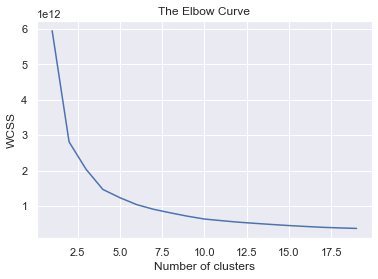

In [93]:
# Plotting an Elbow curve for the same

def elbow_curve(sample = sample):
    wcss = []
    for i in range(1,20):
      kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
      kmeans.fit(sample)
      wcss.append(kmeans.inertia_)
      print('Cluster', i, 'Inertia', kmeans.inertia_)
    plt.plot(range(1,20),wcss)
    plt.title('The Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
    plt.show()

elbow_curve()

In [ ]:
# Unsupervised ML Model -- Extracts features on its own

# Naive Bayes Classifier

In [108]:
# Naive Bayes Model

# Gaussian Process
def GaussianProcess(x,y,parameters=None):
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores=cross_val_score(GaussianProcessClassifier(1.0 * RBF(1.0)), x, y, cv=cv, n_jobs=5, verbose=100)
        model=GaussianProcessClassifier(1.0 * RBF(1.0)).fit(x,y)
        return model

# Naive Bayes Model
def naiveBayes(x,y,parameters=None):
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    scores=cross_val_score(GaussianNB(), x, y, cv=cv, n_jobs=4, verbose=100, scoring='accuracy')
    model=GaussianNB().fit(x,y)
    y_pred = model.predict(x)
    # Create the confusion matrix
    conf_mat = confusion_matrix(y_pred, y, normalize="true")
    return model, conf_mat

# Random Forest Classifier

In [46]:
# RandomForestClassifier
def forest_test(X, Y):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.25, 
                                                        random_state = 101)
    start_time = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
    print(time.process_time() - start_time)
    predictionforest = trainedforest.predict(X_Test)
    print(n_estimators, ' : ', confusion_matrix(Y_Test,predictionforest))
    print(n_estimators, ' : ', classification_report(Y_Test,predictionforest))




50.78125
[[76  6  0  0  0]
 [14 43  8  0  0]
 [ 0 10 53  0 22]
 [ 0  0  0 62  0]
 [ 0  0  0  0 64]]


NameError: name 'classification_report' is not defined

# SVR Classifier

In [ ]:
#SVR Model

def svr(x,y,parameters):
        print ('Running SVR model')
        models=[]
        test_accs=[]
        test_f1s=[]
        for tr_index, ts_index in StratifiedKFold(n_splits=4, shuffle=True, random_state=42).split(x,y):
            print ('\n\nNew Outer CV\n\n')
            grid = GridSearchCV(SVR(), param_grid=parameters, verbose=100,
                            n_jobs=4, scoring=['neg_mean_squared_error'],refit='neg_mean_squared_error')
            grid.fit(x[tr_index], y[tr_index])
            best_model = grid.best_estimator_
            best_model_preds = best_model.predict(x[ts_index])
            test_acc = mean_squared_error(y[ts_index],best_model_preds)
            models.append(best_model)
            test_accs.append(test_acc)
        best_test_acc = min(test_accs)
        best_test_model = models[test_accs.index(best_test_acc)]
        print ("\n\n Nested CV Results: {0} {1}\n\n".format(np.mean(test_accs), np.std(test_accs)))
        return best_test_model
svr()

# SVM default model

In [119]:
def svm(x,y,parameters):
	print ("Running SVM model")
	#C_range = np.logspace(-2, 10, 13)
	#gamma_range = np.logspace(-9, 3, 13)
	#param_grid = dict(gamma=gamma_range, C=C_range)
	models=[]
	test_accs=[]
	test_f1s=[]
	for tr_index, ts_index in StratifiedKFold(n_splits=4, shuffle=True, random_state=42).split(x,y):
		print ("\n\nNew Outer CV\n\n")	
	#outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
		grid = GridSearchCV(SVC(probability=True), param_grid=parameters, verbose=100, 
				n_jobs=4, scoring=['f1_weighted','accuracy'],refit='f1_weighted')
		grid.fit(x[tr_index], y[tr_index])
		best_model = grid.best_estimator_
		best_model_preds = best_model.predict(x[ts_index])
		test_acc = accuracy_score(y[ts_index],best_model_preds)
		test_f1 = f1_score(y[ts_index], best_model_preds, average="weighted")	
		models.append(best_model)
		test_accs.append(test_acc)
		test_f1s.append(test_f1)	
	#non_nested_score=grid.best_score_
	#nested_score = cross_val_score(grid, X=x, y=y, cv=outer_cv)
	#print "Non-nested - Nested: " + str(non_nested_score - nested_score.mean())
	best_test_acc = max(test_accs)
	best_test_model = models[test_accs.index(best_test_acc)]
	print (f'\n\n Nested CV Results: {0} {1} {2} {3}\n\n').format(np.mean(test_accs), np.std(test_accs), np.mean(test_f1s), np.std(test_f1s))
	return best_test_model

In [120]:
svm(a,b, {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']})

Running SVM model


New Outer CV




ValueError: Found input variables with inconsistent numbers of samples: [1334, 1000]

## Getting methane production data:

In [9]:
import pandas as pd
import numpy as np

In [10]:
file = pd.read_excel('./Biogas_Methane_Inhibition_Data.xlsx')

In [11]:
file

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Day 1,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Day 2,Unnamed: 10,100,Unnamed: 12,Unnamed: 13,Unnamed: 14,Day 3,Unnamed: 16
0,NaN,Biogas Production,Error,Methane Inhibited,Error,NaN,NaN,Biogas Production,Error,Methane Inhibited,Error,NaN,NaN,Biogas Production,Error,Methane Inhibited,Error
1,PC,243.33,55.75,68.414501,4.393137,NaN,PC,243.33,55.75,135.997394,6.077892,NaN,PC,243.33,55.75,130.489568,10.89873
2,NC,181.33,27.23,19.529821,1.533201,NaN,NC,181.33,27.23,40.485603,3.776399,NaN,NC,181.33,27.23,41.351527,2.984386
3,TL,168.33,10.41,57.967897,14.577397,NaN,TL,112,3,64.552626,18.389143,NaN,TL,63.67,3.51,35.695382,6.342647
4,TM,160.67,20.03,40.505281,9.108185,NaN,TM,105,4.36,48.057934,3.070957,NaN,TM,61,2,27.133848,5.93206
5,TH,153.33,13.87,56.907218,4.644965,NaN,TH,104.33,1.15,42.706828,9.863196,NaN,TH,57,1,27.237404,7.325356
6,SL,87.33,13.65,26.773666,4.121198,NaN,SL,92,10.82,31.853283,4.823788,NaN,SL,64.33,7.51,27.43991,6.178419
7,SM,73.5,25.94,21.539514,4.564403,NaN,SM,92.67,3.05,39.969003,1.918006,NaN,SM,60,1,26.706948,2.314524
8,SH,123.5,3.61,28.903295,5.320276,NaN,SH,85.33,1.53,34.748659,3.678304,NaN,SH,58.33,3.05,27.790264,2.647783
9,CL,169.67,10.02,61.870269,5.537099,NaN,CL,114.33,5.13,58.248362,4.994843,NaN,CL,45.33,6.11,26.076377,5.192511


In [131]:
# Biogas production data cleaning

day1 = pd.DataFrame(file.iloc[1:12,1:5]).reset_index(drop=True)
day2 = pd.DataFrame(file.iloc[1:12,7:11]).reset_index(drop=True)
day3 = pd.DataFrame(file.iloc[1:12, 13:17]).reset_index(drop=True)
day4 = pd.DataFrame(file.iloc[15:26,1:5]).reset_index(drop=True)
day5 = pd.DataFrame(file.iloc[15:26,7:11]).reset_index(drop=True)

In [133]:
day1

,Unnamed: 1,Unnamed: 2,Day 1,Unnamed: 4
0,243.33,55.75,68.414501,4.393137
1,181.33,27.23,19.529821,1.533201
2,168.33,10.41,57.967897,14.577397
3,160.67,20.03,40.505281,9.108185
4,153.33,13.87,56.907218,4.644965
5,87.33,13.65,26.773666,4.121198
6,73.5,25.94,21.539514,4.564403
7,123.5,3.61,28.903295,5.320276
8,169.67,10.02,61.870269,5.537099
9,156,1,53.578013,3.947188


In [134]:
# Function to plot methane production from day 1 to day 5 for a particular sample

methane_data = pd.concat([day1.iloc[:,2], day2.iloc[:,2], day3.iloc[:,2], day4.iloc[:,2], day5.iloc[:,2]], axis = 1)

In [135]:
methane_data

,Day 1,Day 2,Day 3,Day 1,Day 2
0,68.414501,135.997394,130.489568,128.807944,139.91693
1,19.529821,40.485603,41.351527,60.627685,51.148442
2,57.967897,64.552626,35.695382,20.460905,15.983462
3,40.505281,48.057934,27.133848,20.171365,14.755975
4,56.907218,42.706828,27.237404,17.183434,12.67853
5,26.773666,31.853283,27.43991,25.650289,23.221913
6,21.539514,39.969003,26.706948,22.230406,H23*0.453548344282965
7,28.903295,34.748659,27.790264,17.62806,17.309027
8,61.870269,58.248362,26.076377,17.705453,14.847486
9,53.578013,53.059748,24.787242,14.009386,14.330305
